# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file='traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np


# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_validation)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Load Sign Names

In [4]:
import csv
signnames = []
with open('signnames.csv', newline='') as csvfile:
    signnamesreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in signnamesreader:
        signnames.append(row[1])
    signnames.pop(0)
print('Loaded signnames',len(signnames))

Loaded signnames 43


### Include an exploratory visualization of the dataset

25 Road work


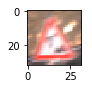

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
signid = y_train[index]
print(signid, signnames[signid])

### Plot Helper

In [6]:
#Function to plot images in a grid with their corresponding class id and name
def plot_signs(images, labels, rows=2, cols=6):

    nimg = min(len(images),rows*cols)
    selection = np.random.choice(images.shape[0], nimg, replace=False)
        
    images_to_show = images[selection]
    
    f, axarr = plt.subplots(rows, cols, figsize=(12, 3*rows))
    for row in range(rows):
        for col in range(cols):
            index = (row*cols)+col
            if index >= len(images_to_show):
                break
                
            ax = axarr[row,col] if rows > 1 else axarr[col]
            ax.imshow(images_to_show[index])
            ax.axis('off')
            
            if labels is not None:
                label_id = labels[selection][index]
                ax.set_title('%s - %s' % (label_id, signnames[label_id]), fontsize=8)

### Plot Training Examples

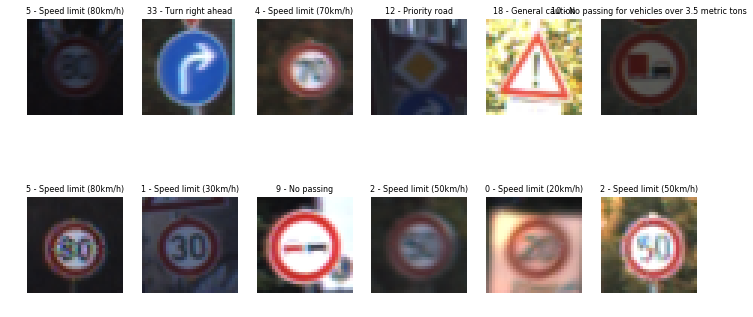

In [7]:
plot_signs(X_train, y_train)

### Plot Test Examples

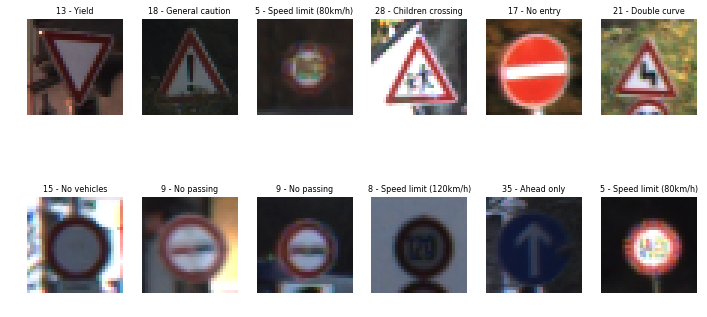

In [8]:
plot_signs(X_test, y_test)

### Plot Validation Examples

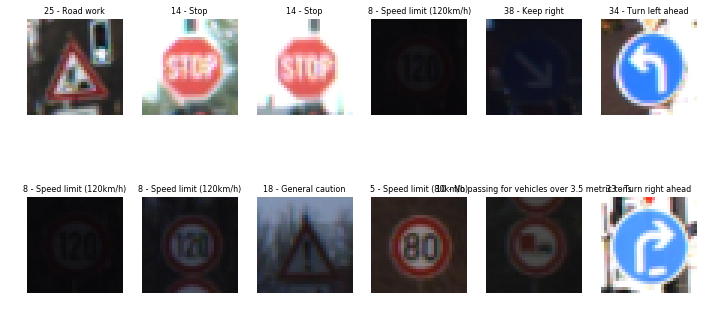

In [9]:
plot_signs(X_validation, y_validation)

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import numpy as np
import cv2
import math

# Get some helper functions from P1

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [11]:
import cv2

def normalize(image):
    empty_image = np.zeros(shape=image.shape)
    return cv2.normalize(image, empty_image, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F) - 0.5

In [12]:
def traffic_sign_image_pipeline(image):
    # grayscaled_image = grayscale(image)
    # kernel_size = 5 # kernel size must be odd
    # gaussian_blur_image = gaussian_blur(grayscaled_image, kernel_size)  
    normalized_image = normalize(image)   
    
    image = normalized_image
    return image

def prepare_images(images):
    new_images =  []
    for image in images:
        new_images.append(traffic_sign_image_pipeline(image))
    return np.array(new_images)

In [13]:
X_train = prepare_images(X_train)
X_test = prepare_images(X_test)
X_validation = prepare_images(X_validation)

### Re-Plot converted images

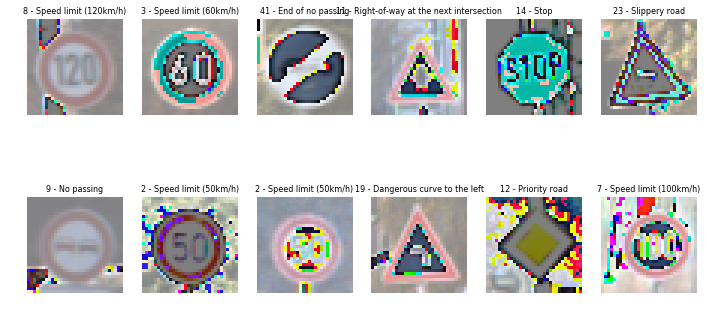

In [14]:
plot_signs(X_train, y_train)

### Shuffle Data

In [15]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [16]:
### adapted LeNet implementation from lab

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.05
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
EPOCHS = 7
BATCH_SIZE = 128
KEEP_PROB = 0.80
RATE = 0.001

In [18]:
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [19]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './signs')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.648
Validation Accuracy = 0.618

EPOCH 2 ...
Training Accuracy = 0.878
Validation Accuracy = 0.791

EPOCH 3 ...
Training Accuracy = 0.942
Validation Accuracy = 0.872

EPOCH 4 ...
Training Accuracy = 0.962
Validation Accuracy = 0.885

EPOCH 5 ...
Training Accuracy = 0.974
Validation Accuracy = 0.917

EPOCH 6 ...
Training Accuracy = 0.977
Validation Accuracy = 0.910

EPOCH 7 ...
Training Accuracy = 0.985
Validation Accuracy = 0.920

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.904


### Predict the Sign Type for Each Image

In [23]:
import os
import matplotlib.image as mpimg

def load_images(folder):
    filenames = os.listdir(folder)
    filenames = list(filter(lambda fn: fn != '.DS_Store', filenames))
    labels = np.array([ int(filename.split('_')[0]) for filename in filenames ])
    return np.array([ mpimg.imread(folder + filename) for filename in filenames ]), labels

X_germany, y_germany = load_images('examples/signs_germany/')
X_international, y_international = load_images('examples/signs_international/')

### Plot german signs

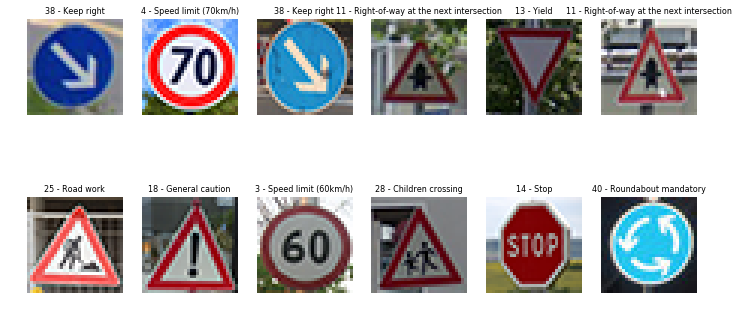

In [24]:
plot_signs(X_germany, y_germany)

### Plot other signs

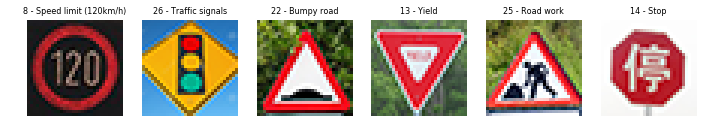

In [25]:
plot_signs(X_international, y_international, rows = 1)

### Predict the Sign Type for Each Image

#### Prepare new images

In [26]:
X_germany = prepare_images(X_germany)
X_international = prepare_images(X_international)

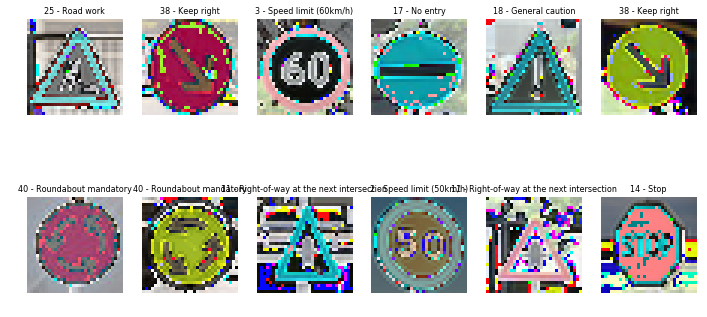

In [27]:
plot_signs(X_germany, y_germany)

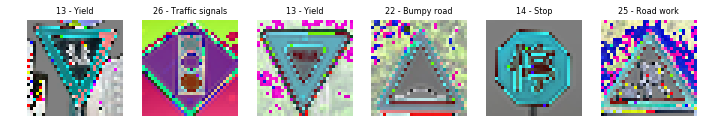

In [28]:
plot_signs(X_international, y_international, rows = 1)

### Analyze Performance

In [29]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

saver = tf.train.Saver()
argmax = tf.argmax(logits, 1)
top_k = tf.nn.top_k(logits, k=5)

result_germany = None
result_international = None

with tf.Session() as sess:
    saver.restore(sess, './signs')
    topk_germany = sess.run(top_k, feed_dict={x: X_germany, keep_prob: 1})
    topk_international = sess.run(top_k, feed_dict={x: X_international, keep_prob: 1})
    
    result_germany = sess.run(argmax, feed_dict={x: X_germany, keep_prob: 1})
    result_international = sess.run(argmax, feed_dict={x: X_international, keep_prob: 1})
    

In [33]:
def error_output(result, correct):
    print('Thought "{}", it should be "{}"'.format(signnames[result], signnames[correct]))

def compare_output(title, zipped):
    counter = 0
    incorrect = 0
    for r, y in zipped:
        counter += 1
        if r != y:
            error_output(r, y)
            incorrect += 1
    print('===> {}: Images {} Errors {} - {:.1f}% Accuracy'.format(title, counter, incorrect, (incorrect*100/counter)))
    
compare_output('Germany', zip(result_germany, y_germany))
compare_output('International', zip(result_international, y_international))

Thought "Ahead only", it should be "Speed limit (50km/h)"
Thought "Ahead only", it should be "Speed limit (60km/h)"
Thought "Keep left", it should be "Speed limit (70km/h)"
===> Germany: Images 15 Errors 3 - 20.0% Accuracy
Thought "No vehicles", it should be "Stop"
Thought "Bicycles crossing", it should be "Bumpy road"
Thought "Right-of-way at the next intersection", it should be "Slippery road"
Thought "Wild animals crossing", it should be "Road work"
Thought "Slippery road", it should be "Traffic signals"
Thought "Stop", it should be "Roundabout mandatory"
Thought "Speed limit (50km/h)", it should be "Speed limit (120km/h)"
===> International: Images 10 Errors 7 - 70.0% Accuracy
